In [90]:
#Google Mobility Report Data

#Import libraries 
import pandas as pd
import pymongo 
import holidays
from prophet import Prophet
import matplotlib.pyplot as plt

Obtenemos los Indicadores Urbanos del Instituto Nacional de Estadística (INE). Está recopilación de datos, proporciona información y mediciones comparables entre los distintos aspectos de la calidad de vida en las ciudades españolas. Esta base de datos es fruto del proyecto Audit, dirigido por la Comisión Europea a través de Eurostat, y es desarrollado por los institutos de estadística de cada país. Concretamente, en el caso español, disponemos de información para aquellos muncipios que cuentan con más de 20.000 habitantes con referencia al 1 de enero de 2022. Mas infromación en: https://www.ine.es/dynt3/metadatos/es/RespuestaDatos.htm?oe=30256

In [91]:
#Conectamos a MongoDB para obtener los datos que requerimos para nuestra investigación

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['MobilityReports'] 
collection = db['Indicadores_Urbanos_INE']

# Suponiendo que ya has establecido la conexión a la base de datos y seleccionado la colección
mi_coleccion = db["mi_coleccion"]

# Consulta MongoDB y carga los documentos en un cursor
data = collection.find()

# Convierte los datos en un DataFrame de Pandas
df = pd.DataFrame(list(data))
df.drop('_id', axis=1, inplace=True)
df = df.dropna(subset=['Total'])
df = df.rename(columns={'Periodo': 'year'})

# Carga la fuente de datos geográficos, para obtener un código por municipio, provincia y CCAA
datos_geograficos = pd.read_csv(r"C:\Users\34645\Desktop\Doctorado_II\Códigos_Python\IEDIS\datos_geograficos.csv", sep = ';')


# Realiza un cruce por el nombre del municipio
#df = df.merge(datos_geograficos, on="Municipios", how="left")

# Define una función para obtener los códigos de provincia, comunidad y municipio
codigo_municipio_dict = {}
for index, row in datos_geograficos.iterrows():
    codigo_municipio_dict[row["Municipios"]] = (row["CPRO"], row["CMUN"])

# Define una función para obtener los códigos de provincia y municipio
def obtener_codigos(row):
    municipio = row["Municipios"]
    codigos = codigo_municipio_dict.get(municipio)
    if codigos:
        return codigos
    else:
        return (None, None)

# Aplica la función a cada fila de df para obtener los códigos
df[["CPRO", "CMUN"]] = df.apply(obtener_codigos, axis=1, result_type="expand")




In [92]:
#Connect to mongoDB 
client = pymongo.MongoClient("mongodb://localhost:27017/")
collection_2 = db['Spain']

#Search query
data_google = collection_2.find()

#Codigos para provincia y CCAA
datos_prov = pd.read_csv(r"C:\Users\34645\Desktop\Doctorado_II\Códigos_Python\IEDIS\ciudades1.csv", sep = ';')
print(datos_prov.columns)


# Convierte los resultados en una lista de diccionarios
datos_google = list(data_google)

# Crea un DataFrame de pandas a partir de la lista de diccionarios
df_mob = pd.DataFrame(datos_google)

df_mob = df_mob.rename(columns={'sub_region_2': 'Provincia'})
df_mob = df_mob.rename(columns={'sub_region_1': 'Comunidad'})
df_mob.drop('_id', axis=1, inplace=True)
df_mob.drop('place_id', axis=1, inplace=True)
df_mob.drop('country_region_code', axis=1, inplace=True)
df_mob.drop('country_region', axis=1, inplace=True)
df_mob.drop('iso_3166_2_code', axis=1, inplace=True)
df_mob['year'] = df_mob['date'].dt.strftime('%Y')
df_mob['year'] = df_mob['year'].astype('int64')

#establecemos código de provincia

codigo_provincia_dict = {'nan': 'nan', 'Almería': 4.0, 'Cádiz': 11.0, 'Córdoba': 14.0, 'Granada': 18.0, 'Huelva': 21.0, 'Jaén': 23.0, 'Málaga': 29.0,
                          'Seville': 41.0, 'Huesca': 22.0, 'Teruel': 44.0, 'Zaragoza': 50.0, 'Álava': 1.0, 'Biscay': 48.0, 'Gipuzkoa': 20.0, 'Las Palmas': 35.0,
                            'Santa Cruz de Tenerife': 38.0, 'Ávila': 5.0, 'Burgos': 9.0, 'León': 24.0, 'Palencia': 34.0, 'Salamanca': 37.0, 'Segovia': 40.0, 'Soria': 42.0, 
                            'Valladolid': 47.0, 'Zamora': 49.0, 'Albacete': 2.0, 'Ciudad Real': 13.0, 'Cuenca': 16.0, 'Guadalajara': 19.0, 'Toledo': 45.0, 'Barcelona': 8.0, 'Girona': 17.0,
                              'Lleida': 25.0, 'Tarragona': 43.0, 'Badajoz': 6.0, 'Cáceres': 10.0, 'A Coruña': 15.0, 'Lugo': 27.0, 'Pontevedra': 36.0, 'Province of Ourense': 32.0, 'Alicante': 3.0,
                                'Castellón': 12.0, 'Valencia': 46.0}


# Define una función para obtener los códigos CPRO
def obtener_codigo_cpro(row):
    provincia = row["Provincia"]
    codigo_cpro = codigo_provincia_dict.get(provincia)
    return codigo_cpro

# Aplica la función para obtener los códigos CPRO y agregarlos a df_mob
df_mob["CPRO"] = df_mob.apply(obtener_codigo_cpro, axis=1, result_type="expand")



print(df_mob.iloc[1000])

Index(['Provincias', 'CPRO'], dtype='object')
date                                                  2020-03-23 00:00:00
retail_and_recreation_percent_change_from_baseline                  -84.0
grocery_and_pharmacy_percent_change_from_baseline                   -51.0
parks_percent_change_from_baseline                                  -80.0
transit_stations_percent_change_from_baseline                       -80.0
workplaces_percent_change_from_baseline                             -68.0
residential_percent_change_from_baseline                             26.0
Comunidad                                                       Andalusia
Provincia                                                           Cádiz
year                                                                 2020
CPRO                                                                 11.0
Name: 1000, dtype: object


In [93]:
#Oxford CGRT data

Stringency_Index = db['Stringency_Index']
GovernmentResponseIndex = db['GovernmentResponseIndex']
EconomicSupportIndex = db['EconomicSupportIndex']
Containment_Health_index = db['Containment_Health_index']


# Realiza la consulta para obtener los datos de España
query = {'CountryName': 'Spain'}  


# Convertir las colecciones a DataFrames
import pandas as pd

# Define una función para aplicar las modificaciones
# Define una función para aplicar las modificaciones y renombrar la columna "Valor"
def aplicar_modificaciones(df):
    # Elimina las columnas innecesarias
    df.drop('_id', axis=1, inplace=True)
    df.drop('CountryCode', axis=1, inplace=True)
    df.drop('Jurisdiction', axis=1, inplace=True)
    
    # Obtiene el nombre del DataFrame
    df_nombre = df.name.split('_')[0]  # Divide el nombre por el guion bajo y toma la primera parte
    
    # Renombra la columna "Valor"
    df.rename(columns={'Valor': f'Valor_{df_nombre}'}, inplace=True)
    
    # Derretir el DataFrame
    df_melted = df.melt(id_vars=['CountryName'], var_name='date', value_name=f'Valor_{df_nombre}')
    
    return df_melted

# Aplica las modificaciones a cada DataFrame y renombra la columna "Valor"
df_stringency = pd.DataFrame(list(Stringency_Index.find(query)))
df_stringency.name = 'Stringency_Index'  # Asigna un nombre al DataFrame
df_stringency = aplicar_modificaciones(df_stringency)

df_government = pd.DataFrame(list(GovernmentResponseIndex.find(query)))
df_government.name = 'GovernmentResponseIndex'
df_government = aplicar_modificaciones(df_government)

df_economic = pd.DataFrame(list(EconomicSupportIndex.find(query)))
df_economic.name = 'EconomicSupportIndex'
df_economic = aplicar_modificaciones(df_economic)

df_containment_health = pd.DataFrame(list(Containment_Health_index.find(query)))
df_containment_health.name = 'Containment_Health_index'
df_containment_health = aplicar_modificaciones(df_containment_health)


# Combina todos los DataFrames en uno solo basado en la columna "date"
df_final = df_stringency.merge(df_government, on='date', how='inner', suffixes=('_stringency', '_government')) \
                      .merge(df_economic, on='date', how='inner', suffixes=('_government', '_economic')) \
                      .merge(df_containment_health, on='date', how='inner', suffixes=('_economic', '_containment_health'))
df_final.drop(['CountryName_government', 'CountryName_economic', 'CountryName_containment_health'], axis=1, inplace=True)


df_final['date'] = pd.to_datetime(df_final['date'], format='%d%b%Y').dt.strftime('%Y-%m-%d')
df_final['date'] = df_final['date'].astype('datetime64[ns]')
df_final['year'] = df_final['date'].dt.strftime('%Y')


print(df_final)





     CountryName_stringency       date Valor_Stringency  \
0                     Spain 2020-01-01                0   
1                     Spain 2020-01-02                0   
2                     Spain 2020-01-03                0   
3                     Spain 2020-01-04                0   
4                     Spain 2020-01-05                0   
...                     ...        ...              ...   
1091                  Spain 2022-12-27             5,56   
1092                  Spain 2022-12-28             5,56   
1093                  Spain 2022-12-29             5,56   
1094                  Spain 2022-12-30             5,56   
1095                  Spain 2022-12-31             5,56   

     Valor_GovernmentResponseIndex Valor_EconomicSupportIndex  \
0                                0                          0   
1                                0                          0   
2                                0                          0   
3                              

In [94]:
#Crear nuestro panel de datos 

df_pivot = df.pivot(index=['Sexo', 'year', 'Municipios', 'CPRO'], columns='Indicadores', values='Total')


# Si tienes valores duplicados para las mismas categorías, puedes usar pivot_table
#df_pivot = df.pivot_table(index='Periodo', columns='Indicadores', values='Total', aggfunc='mean')

# Resetear el índice si lo deseas
df_pivot.reset_index(inplace=True)


#print(df_pivot)

# Filtra las filas donde el valor de la columna "Sexo" es "Total"
df_ine = df_pivot[df_pivot['Sexo'] == 'Total']
df_ine.drop('Sexo', axis=1, inplace=True)
print(df_ine)




Indicadores  year            Municipios  CPRO  \
2282         2010                   NaN   NaN   
2283         2010      Alacant/Alicante   NaN   
2284         2010              Albacete   2.0   
2285         2010     Alcalá de Henares  28.0   
2286         2010            Alcobendas  28.0   
...           ...                   ...   ...   
3860         2022  Vilanova i la Geltrú   8.0   
3861         2022       Vitoria-Gasteiz   1.0   
3862         2022                Zamora  49.0   
3863         2022              Zaragoza  50.0   
3864         2022                 Ávila   5.0   

Indicadores Duración media del desplazamiento al trabajo (Minutos)  \
2282                                                        ..       
2283                                                        ..       
2284                                                        ..       
2285                                                        ..       
2286                                                        .

C:\Users\34645\AppData\Local\Temp\ipykernel_28224\3179534199.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ine.drop('Sexo', axis=1, inplace=True)


In [95]:
# Realiza una unión basada en la columna "Municipios"
# Fusionar ambos DataFrames en función de las columnas 'Municipios' y 'year' y rellenar los valores nulos
df_final['year'] = df_final['year'].astype('int64')  # Cambiar el tipo de dato a 'object'

df_unido = df_ine.merge(df_final, on=['year'], how='left').fillna(method='ffill')


dataset = df_mob.merge(df_unido, on=['CPRO', 'date'], how='left')

# Especifica la ruta y el nombre del archivo CSV
ruta_archivo_csv = r'C:\Users\34645\Desktop\Doctorado_II\Códigos_Python\IEDIS\Data\dataset.csv'

#Filtramos para eliminar las filas que no contienen Municipio

dataset = dataset.dropna(subset=["Municipios"])

# Utiliza to_csv para exportar el DataFrame a un archivo CSV
#dataset.to_csv(ruta_archivo_csv, index=False)  # index=False para no incluir el índice en el archivo CSV


C:\Users\34645\AppData\Local\Temp\ipykernel_28224\3446778930.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_unido = df_ine.merge(df_final, on=['year'], how='left').fillna(method='ffill')


In [96]:
print(dataset.columns)

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'Comunidad', 'Provincia',
       'year_x', 'CPRO', 'year_y', 'Municipios',
       'Duración media del desplazamiento al trabajo (Minutos)',
       'Edad mediana de la población (años)',
       'Esperanza de vida al nacer (Años)',
       'Número de pernoctaciones turísticas anuales (Número)',
       'Número de plazas disponibles en establecimientos turísticos (Número)',
       'Número de viviendas convencionales según Catastro (Número)',
       'Número de viviendas convencionales según Censo (Número)',
       'Número medio de hijos por mujer (Número)',
       'Número total de hogares (Número)', 'Población residente (Personas)',
       'Porcentaje de desplazamien

In [97]:
print(dataset['Municipios'].value_counts())
conteos = {}

# Calcula las cuentas de cada identificador
for identificador in dataset['Municipios']:
    if identificador in conteos:
        conteos[identificador] += 1
    else:
        conteos[identificador] = 1

# Verifica si todas las cuentas son iguales
repeticiones_iguales = all(count == list(conteos.values())[0] for count in conteos.values())

if repeticiones_iguales:
    print("Todos los identificadores se repiten el mismo número de veces.")
else:
    print("Los identificadores no se repiten el mismo número de veces.")

    # Encuentra el identificador con el recuento máximo
identificador_mas_frecuente = max(conteos, key=conteos.get)
recuento_maximo = conteos[identificador_mas_frecuente]

print("El identificador que se repite más veces es '{}' con un recuento de {}.".format(identificador_mas_frecuente, recuento_maximo))

dataset = dataset[dataset['Municipios'] != identificador_mas_frecuente]

Municipios
Ávila                                              1948
Almería                                             974
Mataró                                              974
Santa Coloma de Gramenet                            974
Sant Vicent del Raspeig/San Vicente del Raspeig     974
                                                   ... 
Santa Lucía de Tirajana                             974
Arrecife                                            974
Irun                                                974
Donostia/San Sebastián                              974
Torrent                                             974
Name: count, Length: 91, dtype: int64
Los identificadores no se repiten el mismo número de veces.
El identificador que se repite más veces es 'Ávila' con un recuento de 1948.


In [98]:
# Supongamos que tienes un DataFrame llamado dataset con una columna 'date' que contiene las fechas
# Asegúrate de que la columna 'date' esté en formato de fecha (datetime)
dataset['date'] = pd.to_datetime(dataset['date'])

# Define la fecha de inicio y la fecha de fin del intervalo
fecha_inicio = pd.to_datetime('2020-02-15')
fecha_fin = pd.to_datetime('2022-10-15')

# Calcula el número de período para cada fecha
dataset['Periodo'] = (dataset['date'] - fecha_inicio).dt.days + 1

# Muestra el DataFrame resultante
print(dataset)


             date  retail_and_recreation_percent_change_from_baseline  \
642    2020-02-15                                                5.0    
643    2020-02-16                                               -2.0    
644    2020-02-17                                                0.0    
645    2020-02-18                                               -3.0    
646    2020-02-19                                               -1.0    
...           ...                                                ...    
113940 2022-10-14                                              -12.0    
113941 2022-10-14                                              -12.0    
113942 2022-10-15                                              -17.0    
113943 2022-10-15                                              -17.0    
113944 2022-10-15                                              -17.0    

        grocery_and_pharmacy_percent_change_from_baseline  \
642                                                  -3.0   
6

In [99]:
#remove unnecesary columns
print(dataset.columns)
dataset = dataset.drop(columns=['year_x','year_y', 'CountryName_stringency'])

# Utiliza to_csv para exportar el DataFrame a un archivo CSV
#dataset.to_csv(ruta_archivo_csv, index=False)  # index=False para no incluir el índice en el archivo CSV

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'Comunidad', 'Provincia',
       'year_x', 'CPRO', 'year_y', 'Municipios',
       'Duración media del desplazamiento al trabajo (Minutos)',
       'Edad mediana de la población (años)',
       'Esperanza de vida al nacer (Años)',
       'Número de pernoctaciones turísticas anuales (Número)',
       'Número de plazas disponibles en establecimientos turísticos (Número)',
       'Número de viviendas convencionales según Catastro (Número)',
       'Número de viviendas convencionales según Censo (Número)',
       'Número medio de hijos por mujer (Número)',
       'Número total de hogares (Número)', 'Población residente (Personas)',
       'Porcentaje de desplazamien

Cargados los datos necesarios para el análisis, procedemos con el proccesamiento de los mismos. En este caso, necesitamos eliminar los posibles efectos estacionales derivados de las vacaciones de verano y los posibles efectos producidos por los festivos nacionales en España. Para ello, utilizamos la librería de Python de Prophet, que nos permite descomponer la serie temporal en efectos derivados de las vacaciones, anuales, semanales e incluso diarios. En este caso, eliminamos la estacionalidad semanal (causada por el fin de semana) y los festivos nacionales. 

In [100]:
#Predicción pormunicipio.

def get_prediction(df):
    prediction = {}
    lista_municipios = df.Municipios.unique()
    df.rename(columns={'date': 'ds', 'workplaces_percent_change_from_baseline': 'y'}, inplace=True)
    #Festivos

    fiesta = holidays.Spain(years=df['ds'].dt.year.unique())
    festivos_espana = [fecha.strftime('%Y-%m-%d') for fecha in fiesta.keys()]
    festivos = pd.DataFrame({
   'holiday': 'Festivos España',
   'ds': pd.to_datetime(festivos_espana),
   'lower_window': 0,
   'upper_window': 2,
 })

    for municipio in lista_municipios:
        municipio_df = df.loc[df['Municipios'] == municipio]
        # set the uncertainty interval to 95% (the Prophet default is 80%)
        my_model = Prophet( yearly_seasonality=5,holidays=festivos).fit(municipio_df)
        future_dates = my_model.make_future_dataframe(periods=365, freq='D')
        forecast = my_model.predict(future_dates)
        prediction[municipio] = forecast
    return prediction

In [101]:
prediction = get_prediction(dataset)

18:33:07 - cmdstanpy - INFO - Chain [1] start processing
18:33:07 - cmdstanpy - INFO - Chain [1] done processing
18:33:07 - cmdstanpy - INFO - Chain [1] start processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing
18:33:08 - cmdstanpy - INFO - Chain [1] start processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing
18:33:08 - cmdstanpy - INFO - Chain [1] start processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing
18:33:08 - cmdstanpy - INFO - Chain [1] start processing
18:33:09 - cmdstanpy - INFO - Chain [1] done processing
18:33:09 - cmdstanpy - INFO - Chain [1] start processing
18:33:09 - cmdstanpy - INFO - Chain [1] done processing
18:33:09 - cmdstanpy - INFO - Chain [1] start processing
18:33:09 - cmdstanpy - INFO - Chain [1] done processing
18:33:10 - cmdstanpy - INFO - Chain [1] start processing
18:33:10 - cmdstanpy - INFO - Chain [1] done processing
18:33:10 - cmdstanpy - INFO - Chain [1] start processing
18:33:10 - cmdstanpy - INFO - Chain [1]

In [102]:
df = pd.DataFrame(columns=['ds', 'trend', 'Municipios'])

# Iterar a través del diccionario y agregar los datos al DataFrame
for municipio, data in prediction.items():
    temp_df = pd.DataFrame(data)
    temp_df['Municipios'] = municipio
    df = pd.concat([df, temp_df], ignore_index=True)

# Asegúrate de convertir la columna 'ds' a tipo datetime si aún no lo está
df['date'] = pd.to_datetime(df['ds'])



C:\Users\34645\AppData\Local\Temp\ipykernel_28224\3892761397.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)


In [109]:
print(dataset)

               ds  retail_and_recreation_percent_change_from_baseline  \
642    2020-02-15                                                5.0    
643    2020-02-16                                               -2.0    
644    2020-02-17                                                0.0    
645    2020-02-18                                               -3.0    
646    2020-02-19                                               -1.0    
...           ...                                                ...    
113940 2022-10-14                                              -12.0    
113941 2022-10-14                                              -12.0    
113942 2022-10-15                                              -17.0    
113943 2022-10-15                                              -17.0    
113944 2022-10-15                                              -17.0    

        grocery_and_pharmacy_percent_change_from_baseline  \
642                                                  -3.0   
6

In [110]:
#Merge dataframe

#data = pd.read_csv(r'C:\Users\34645\Desktop\Doctorado_II\Códigos_Python\IEDIS\Data\dataset.csv')

# Convertir la columna "Fecha" a tipo datetime
dataset['ds'] = pd.to_datetime(dataset['ds'])
dataset = pd.merge(dataset, df, left_on=['ds', 'Municipios'], right_on=['ds', 'Municipios'], how='inner')

In [112]:
dataset['trend_yearly'] = dataset['trend'] + dataset['yearly'] 
dataset.rename(columns={'ds': 'date', 'y': 'workplaces_percent_change_from_baseline'}, inplace=True)

In [118]:
dataset.rename(columns={'ds': 'date', 'y': 'workplaces_percent_change_from_baseline'}, inplace=True)

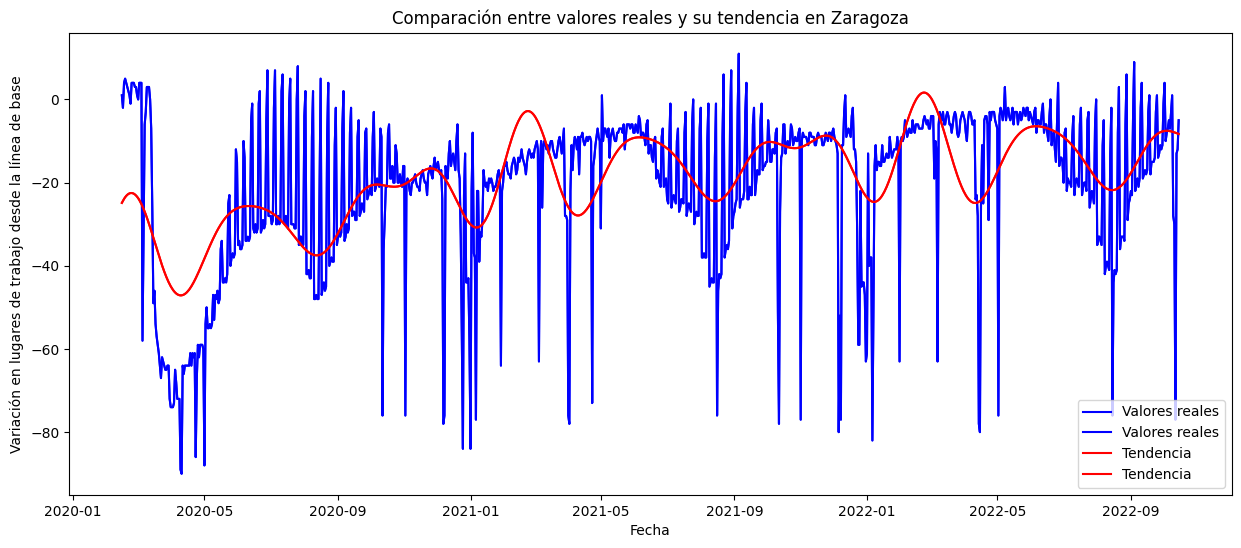

In [119]:
# Filtra los datos solo para la ciudad de 'Zaragoza'
zaragoza_data = dataset[dataset['Municipios'] == 'Zaragoza']

# Configura el tamaño del gráfico
plt.figure(figsize=(15, 6))

# # Grafica la serie temporal 'workplaces_percent_change_from_baseline' para Zaragoza
plt.plot(zaragoza_data['date'], zaragoza_data['workplaces_percent_change_from_baseline'], label='Valores reales', color='blue')

# Grafica la serie temporal 'trend' para Zaragoza
plt.plot(zaragoza_data['date'], zaragoza_data['trend_yearly'], label='Tendencia', color='red')

# Configura etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Variación en lugares de trabajo desde la línea de base')
plt.title('Comparación entre valores reales y su tendencia en Zaragoza')
plt.legend()

# Muestra el gráfico
plt.show()

In [121]:
print(dataset.columns)

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'Comunidad', 'Provincia',
       'CPRO', 'Municipios',
       'Duración media del desplazamiento al trabajo (Minutos)',
       'Edad mediana de la población (años)',
       'Esperanza de vida al nacer (Años)',
       'Número de pernoctaciones turísticas anuales (Número)',
       'Número de plazas disponibles en establecimientos turísticos (Número)',
       'Número de viviendas convencionales según Catastro (Número)',
       'Número de viviendas convencionales según Censo (Número)',
       'Número medio de hijos por mujer (Número)',
       'Número total de hogares (Número)', 'Población residente (Personas)',
       'Porcentaje de desplazamientos al trabajo a pie

In [126]:


# Eliminar las columnas vacías
dataset = dataset.dropna(axis=1, how='all')


In [127]:
ruta_archivo_csv = r'C:\Users\34645\Desktop\Doctorado_II\Códigos_Python\IEDIS\Data\dataset.csv'
dataset.to_csv(ruta_archivo_csv, index=False)  # index=False para no incluir el índice en el archivo CSV